In [10]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim

from PIL import Image
import os

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.utils import compute_class_weight
from sklearn.model_selection import train_test_split

import seaborn as sns


In [2]:


class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        # Getting the list of folders
        self.samples = sorted(os.listdir(root_dir))

        # Creating a dictionary for the supervised learning
        self.class_to_label = {}
        label_counter = 0

        #assigning labels
        for sample_name in self.samples:
            if sample_name.startswith("Sample") and label_counter <= 61:
                label = label_counter
                

            self.class_to_label[sample_name] = label
            label_counter += 1

        # Initialize lists to store file paths and labels
        self.file_paths = []
        self.labels = []

        # Populate file_paths and labels based on the folder structure
        for sample_name in self.samples:
            sample_path = os.path.join(root_dir, sample_name)
            label = self.class_to_label[sample_name]
            for filename in os.listdir(sample_path):
                file_path = os.path.join(sample_path, filename)
                self.file_paths.append(file_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]

        #print(f"Image shape: {image.shape if isinstance(image, torch.Tensor) else 'Not a tensor'}")  # Add this line for debugging
        #print(f"Label: {label}")

        return image, label

    def remove_item(self, index):
        self.file_paths.pop(index)
        self.labels.pop(index)


In [3]:
root_folder = "datast"
transform = transforms.Compose([transforms.Resize((128, 128)),
                                transforms.ToTensor(),
                                ])

custom_dataset = CustomDataset(root_folder, transform=transform)

# chcking
sample_image, sample_label = custom_dataset[54000]

# loader for traning
batch_size = 32
data_loader = torch.utils.data.DataLoader(custom_dataset, batch_size=batch_size, shuffle=True)

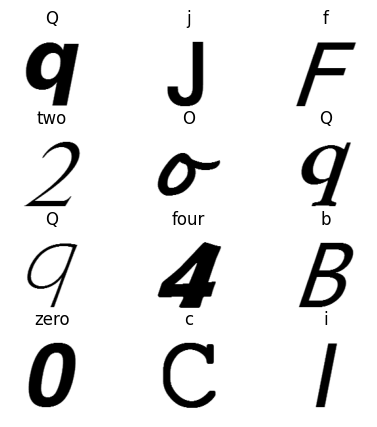

In [5]:
labels_map = {
    
    0: 'zero',
    1: 'one',
    2: 'two',
    3: 'three',
    4: 'four',
    5: 'five',
    6: 'six',
    7: 'seven',
    8: 'eight',
    9: 'nine',
    10: 'a',
    11: 'b',
    12: 'c',
    13: 'd',
    14: 'e',
    15: 'f',
    16: 'g',
    17: 'h',
    18: 'i',
    19: 'j',
    20: 'k',
    21: 'l',
    22: 'm',
    23: 'n',
    24: 'o',
    25: 'p',
    26: 'q',
    27: 'r',
    28: 's',
    29: 't',
    30: 'u',
    31: 'v',
    32: 'w',
    33: 'x',
    34: 'y',
    35: 'z',
    36: 'A',
    37: 'B',
    38: 'C',
    39: 'D',
    40: 'E',
    41: 'F',
    42: 'G',
    43: 'H',
    44: 'I',
    45: 'J',
    46: 'K',
    47: 'L',
    48: 'M',
    49: 'N',
    50: 'O',
    51: 'P',
    52: 'Q',
    53: 'R',
    54: 'S',
    55: 'T',
    56: 'U',
    57: 'V',
    58: 'W',
    59: 'X',
    60: 'Y',
    61: 'Z',

}

figure = plt.figure(figsize=(5, 5))
cols, rows = 3, 4

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(custom_dataset), size=(1,)).item()
    img, label = custom_dataset[sample_idx]
    
    img = img.permute(1, 2, 0)
    
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img)
    
plt.show()

In [6]:
class OCRNN(nn.Module):
    def __init__(self):
        super(OCRNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 16, 3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc_input_size = self.calculate_fc_input_size()

        self.dropout = nn.Dropout(0.5)

        self.fc = nn.Linear(self.fc_input_size, 62)  


    def forward(self, x):
        x = self.layers(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layer
        x = self.fc(x)

        return x

    def calculate_fc_input_size(self):
        dummy_input = torch.randn((1, 3, 128, 128))
        dummy_output = self.layers(dummy_input)
        return dummy_output.view(dummy_output.size(0), -1).size(1)

In [7]:

if torch.cuda.is_available():
    device = torch.device("cuda:0")  # Specify the GPU index
    print(f"GPU (CUDA) is available. Using GPU {torch.cuda.current_device()}.")
else:
    device = torch.device("cpu")
    print("GPU is not available. Using CPU.")

GPU (CUDA) is available. Using GPU 0.


In [8]:
model = OCRNN()
model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()

    for inputs, labels in data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        # Unpack the tuple and get the label tensor
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')



Epoch 1/10, Loss: 0.2409605085849762
Epoch 2/10, Loss: 0.7981656789779663
Epoch 3/10, Loss: 0.3283807039260864
Epoch 4/10, Loss: 1.4040697813034058
Epoch 5/10, Loss: 0.2172882854938507
Epoch 6/10, Loss: 0.8117048740386963
Epoch 7/10, Loss: 0.21426671743392944
Epoch 8/10, Loss: 0.22432178258895874
Epoch 9/10, Loss: 0.2956041693687439
Epoch 10/10, Loss: 0.15778401494026184


In [ ]:
model.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels in validation_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)

        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

In [ ]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(15, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels_map.values(), yticklabels=labels_map.values())
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()